## Training & Benchmarking for Dynamic Pricing
This notebook contains script for model training of the dyanmic pricing algorithms. 

### Fetching training and validation data from S3

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import sqlalchemy
import pandas as pd

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [3]:
!aws s3 sync "s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/" "../data/train"

download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/_SUCCESS to ../data/train/_SUCCESS
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/part-00000 to ../data/train/part-00000
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/part-00003 to ../data/train/part-00003
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/part-00006 to ../data/train/part-00006
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/part-00004 to ../data/train/part-00004
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/train/part-00002 to ../data/train/part-00002
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/

In [8]:
!aws s3 sync "s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/" "../data/validation"

download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/_SUCCESS to ../data/validation/_SUCCESS
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/part-00000 to ../data/validation/part-00000
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/part-00003 to ../data/validation/part-00003
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/part-00006 to ../data/validation/part-00006
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/part-00009 to ../data/validation/part-00009
download: s3://keawsbucket/sagemaker/spark-dynamic-pricing/2021-06-18-20-21-19/input/preprocessed/pricing/validation/part-00002 to ../data/validation/part-00002
download: s3://keawsbucket/sagemaker/s

In [2]:
#Load all training/validation data into one dataframe
import glob 

train_files = glob.glob("../data/train/part*")
li = []
for filename in train_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

train_df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
import glob

validation_files = glob.glob("../data/validation/part*")
li = []
for filename in validation_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

validation_df = pd.concat(li, axis=0, ignore_index=True)

In [20]:
#Seperate training labels and training data (first column is predefined as labels)
train_y = train_df.iloc[:,0]
train_x = train_df.iloc[:,1:]

In [5]:
#Seperate validation labels and validation data
validation_y = validation_df.iloc[:,0]
validation_x = validation_df.iloc[:,1:]

## XGBoost Baseline Model

In [29]:
import xgboost

model = xgboost.XGBRegressor()

In [30]:
model.fit(train_x, train_y)

[17:46:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [31]:
pred_y = model.predict(validation_x)

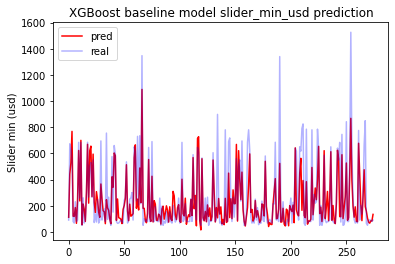

In [39]:
import matplotlib.pyplot as plt

plt.plot()
plt.ylabel('Slider min (usd)')
plt.title('XGBoost baseline model slider_min_usd prediction')
plt.plot(pred_y, 'r', label='pred')
plt.plot(validation_y, 'b', label='real', alpha=0.3)
plt.legend()
plt.savefig('XGBoost_slider_min_usd.png', dpi=300)

In [35]:
import numpy as np

def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

smape(validation_y, pred_y)

38.22321377617614

In [36]:
from sklearn.metrics import r2_score

r2_score(validation_y, pred_y)

0.6224348631819908

In [38]:
diff_y = pred_y - validation_y

l1_loss = np.mean(np.abs(diff_y))
l2_loss = np.mean(diff_y ** 2)

print("L1: {:.3f}    L2: {:.3f}".format(l1_loss, l2_loss))

L1: 92.084    L2: 26939.067


## MLP Baseline Model

In [60]:
import torch
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hid1 = nn.Linear(36, 100)  # 8-(10-10)-1
    self.hid2 = nn.Linear(100, 10)
    self.oupt = nn.Linear(10, 1)

    nn.init.xavier_uniform_(self.hid1.weight)
    nn.init.zeros_(self.hid1.bias)
    nn.init.xavier_uniform_(self.hid2.weight)
    nn.init.zeros_(self.hid2.bias)
    nn.init.xavier_uniform_(self.oupt.weight)
    nn.init.zeros_(self.oupt.bias)

  def forward(self, x):
    z = torch.relu(self.hid1(x))
    z = torch.relu(self.hid2(z))
    z = self.oupt(z)  # no activation
    return z

In [24]:
train_x.values.shape

(1074, 36)

In [61]:
import numpy as np

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

torch_train_x = torch.tensor(train_x.values.astype(np.float32))
torch_train_y = torch.tensor(train_y.values.astype(np.float32))

print("Training Start")

for e in range(386):
    out = net(torch_train_x)

    loss = criterion(out, torch_train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))


Training Start
Epoch:    0, Loss: 89446.29688
Epoch:   64, Loss: 57870.20312
Epoch:  128, Loss: 56889.07812
Epoch:  192, Loss: 56259.58984
Epoch:  256, Loss: 56086.08984
Epoch:  320, Loss: 56009.89844
Epoch:  384, Loss: 55974.27734


In [49]:
import math
import torch.nn as nn
import torch.nn.functional as F
from layers.ModulatedAttLayer import ModulatedAttLayer


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def fc(in_planes, out_planes):
    return nn.Linear(in_planes, out_planes)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.fc1 = fc(inplanes, planes)
        #self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = fc(planes, planes)
        #self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.fc1 = fc(inplanes, planes)
        #self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        #self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
        #                       padding=1, bias=False)
        self.fc2 = fc(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.fc3 = nn.Conv2d(planes, planes*4)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        #out = self.conv1(x)
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)

        #out = self.conv2(out)
        out = self.fc2(2)
        out = self.bn2(out)
        out = self.relu(out)

        #out = self.conv3(out)
        out = self.fc3(x)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, use_modulatedatt=False, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()
        #self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
        #                       bias=False)
        self.fc1 = fc(36, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False

        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512 * block.expansion, 512)

        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        self.use_modulatedatt = use_modulatedatt
        if self.use_modulatedatt:
            print('Using self attention.')
            self.modulatedatt = ModulatedAttLayer(in_channels=512 * block.expansion)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, *args):
        #x = self.conv1(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.use_modulatedatt:
            x, feature_maps = self.modulatedatt(x)
        else:
            feature_maps = None

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        if self.use_fc:
            x = F.relu(self.fc_add(x))

        if self.use_dropout:
            x = self.dropout(x)

        return x, feature_maps

In [50]:
resnet152 = ResNet(Bottleneck, [3, 8, 36, 3], use_modulatedatt=False, use_fc=False, dropout=None)

TypeError: __init__() missing 1 required positional argument: 'kernel_size'

In [48]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
criterion = nn.MSELoss()

torch_train_x = torch.tensor(train_x.values.astype(np.float32))
torch_train_y = torch.tensor(train_y.values.astype(np.float32))

print("Training Start")

for e in range(386):
    out = resnet152(torch_train_x)

    loss = criterion(out, torch_train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))

Training Start


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 2-dimensional input of size [1074, 36] instead